$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
from tabulate import tabulate
from fractions import Fraction

### 簡単な演習:

上記の回路を $a=2,8,11$ の値に変更します。どのような結果が得られますか? またその理由は何ですか?
***

テキストのコードを使用して、$a=2, 8, 11$のときを順に見ていく。  
先にいくつか関数を用意しておく。

In [2]:
def c_amod15(a, power):
    """mod 15による制御ゲートをかける"""
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U

In [3]:
def qft_dagger(n):
    """n量子ビットの逆QFTを回路の最初のn量子ビットにかける"""
    qc = QuantumCircuit(n)
    # Swapsを忘れない!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cu1(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc


In [4]:
def plot_fx(N, a, xlim):
    
    # プロットするデータを計算する
    xvals = np.arange(xlim)
    yvals = [np.mod(a**x, N) for x in xvals]

    # matplotlibを使って描画
    fig, ax = plt.subplots()
    ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
    ax.set(xlabel='$x$', ylabel='$%i^x$ mod $%i$' % (a, N),
           title="Example of Periodic Function in Shor's Algorithm")
    try: # グラフ上にrをプロット
        r = yvals[1:].index(1) +1 
        plt.annotate(text='', xy=(0,1), xytext=(r,1), arrowprops=dict(arrowstyle='<->'))
        plt.annotate(text='$r=%i$' % r, xy=(r/3,1.5))
    except:
        print('Could not find period, check a < N and have no common factors.')

***
### a = 2 のとき：  
　まず、関数 $f(x)=a^x\ \rm{mod}\ \it{N}$ の周期 $r$ をグラフ上で確認しておく。

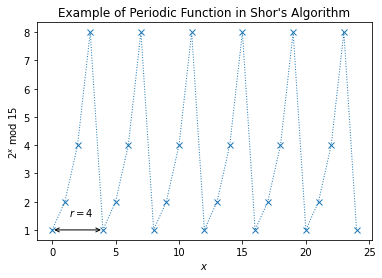

In [5]:
plot_fx(N = 15,a = 2, xlim = 25)

改めて量子位相推定(QPE)の回路を構成し、周期 $r$ のヒントとなる位相を測定する。

C:\Users\WataruOgaki\AppData\Local\Temp\ipykernel_24164\2071727995.py:9: DeprecationWarning: The QuantumCircuit.cu1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cp method instead, which acts identically.
  qc.cu1(-np.pi/float(2**(j-m)), m, j)


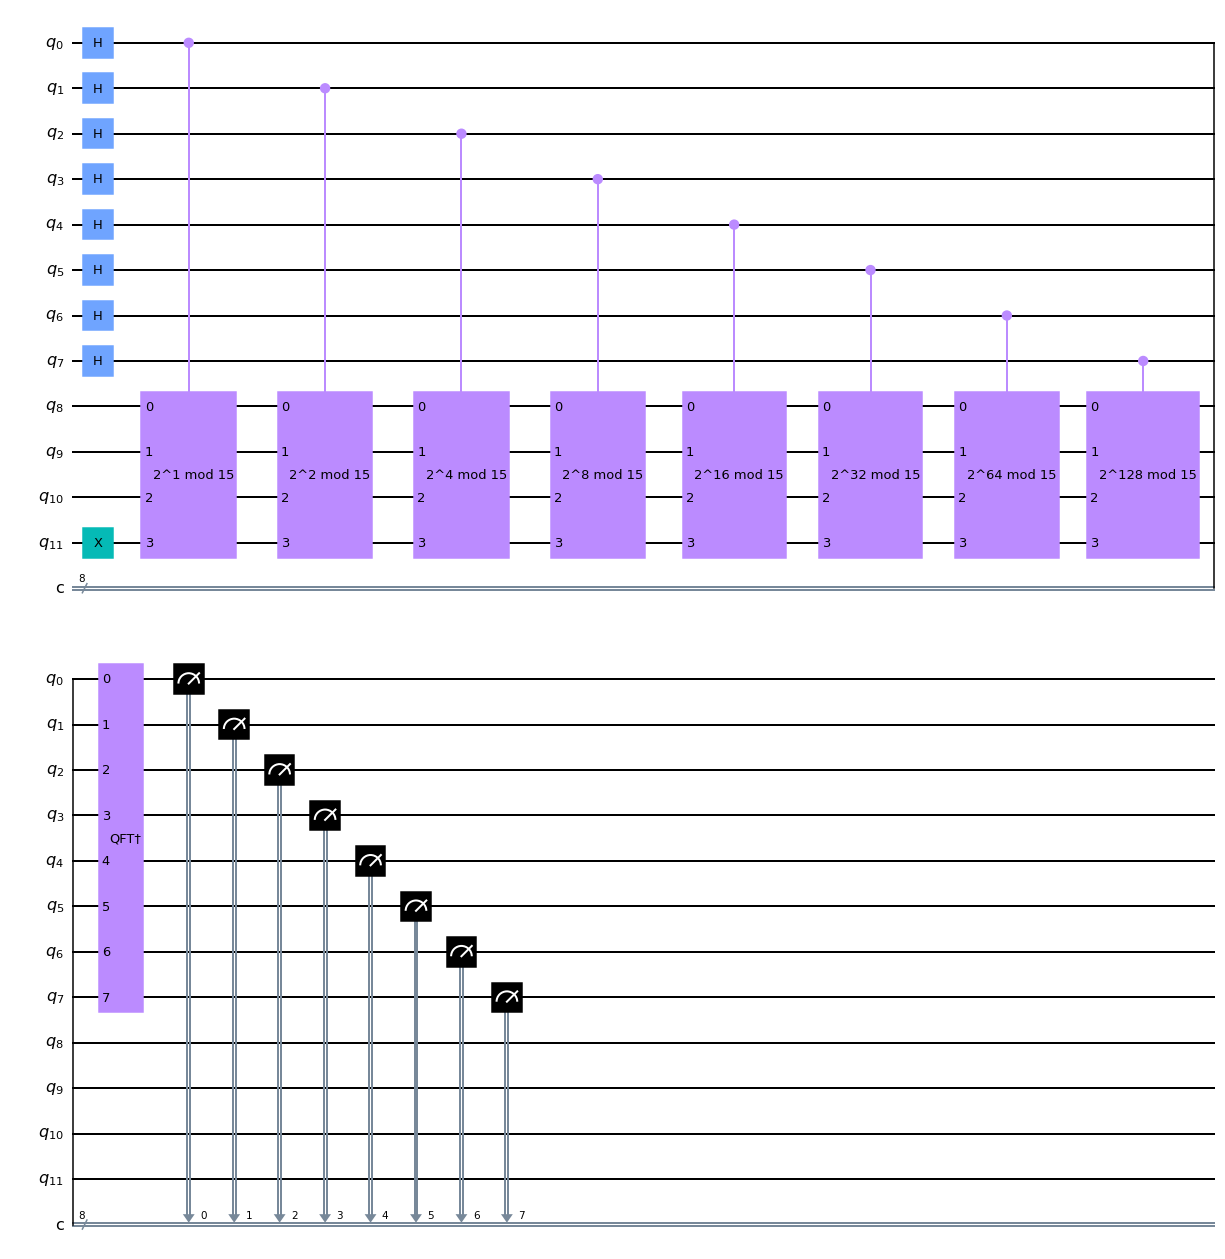

In [6]:
# Specify variables
n_count = 8 # number of counting qubits
a = 2

# n_count個の測定用量子ビットとUを操作するための4量子ビットで
# 量子回路を作る
qc = QuantumCircuit(n_count + 4, n_count)

# 測定用量子ビットを
# |+>状態に初期化
for q in range(n_count):
    qc.h(q)

# アンシラレジスターを|1>の状態にする
qc.x(3+n_count)

# 制御Uを操作
for q in range(n_count):
    qc.append(c_amod15(a, 2**q), 
             [q] + [i+n_count for i in range(4)])

# 逆QFTを操作
qc.append(qft_dagger(n_count), range(n_count))

# 回路を測定
qc.measure(range(n_count), range(n_count))
qc.draw('mpl')

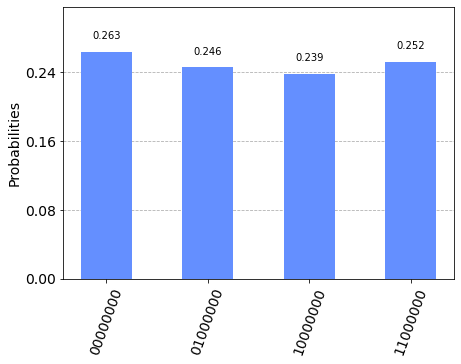

In [7]:
backend = Aer.get_backend('qasm_simulator')
results = execute(qc, backend, shots=2048).result()
counts = results.get_counts()
plot_histogram(counts)

In [8]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # 2進数を10進数に変換します
    phase = decimal/(2**n_count) # 固有値を探します
    measured_phases.append(phase)
    # これらの値をテーブルの行に追加します：
    rows.append(["%s(bin) = %i(dec)" % (output, decimal), 
                 "%i/%i = %.2f" % (decimal, 2**n_count, phase)])
# tabulateを使って、ASCIIテーブルとして行を印刷します：
print(tabulate(rows, 
               headers=["Register Output", "Phase"], 
               colalign=("left","right")))

Register Output                    Phase
------------------------  --------------
01000000(bin) = 64(dec)    64/256 = 0.25
10000000(bin) = 128(dec)  128/256 = 0.50
11000000(bin) = 192(dec)  192/256 = 0.75
00000000(bin) = 0(dec)      0/256 = 0.00


In [9]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, "%i/%i" % (frac.numerator, frac.denominator), frac.denominator])
# ASCIIテーブルを表示
print(tabulate(rows, 
               headers=["Phase", "Fraction", "Guess for r"], 
               colalign=('right','right','right')))

  Phase    Fraction    Guess for r
-------  ----------  -------------
   0.25         1/4              4
    0.5         1/2              2
   0.75         3/4              4
      0         0/1              1


測定された固有値の内、2つが正しい結果を与えたことが分かる。：$r = 4$
***

### a = 8 のとき：  
　まず、関数 $f(x)=a^x\ \rm{mod}\ \it{N}$ の周期 $r$ をグラフ上で確認しておく。

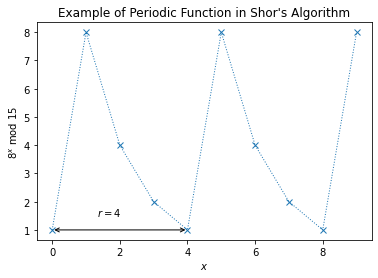

In [10]:
plot_fx(N = 15, a = 8, xlim = 10)

改めて量子位相推定(QPE)の回路を構成し、周期 $r$ のヒントとなる位相を測定する。

C:\Users\WataruOgaki\AppData\Local\Temp\ipykernel_24164\2071727995.py:9: DeprecationWarning: The QuantumCircuit.cu1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cp method instead, which acts identically.
  qc.cu1(-np.pi/float(2**(j-m)), m, j)


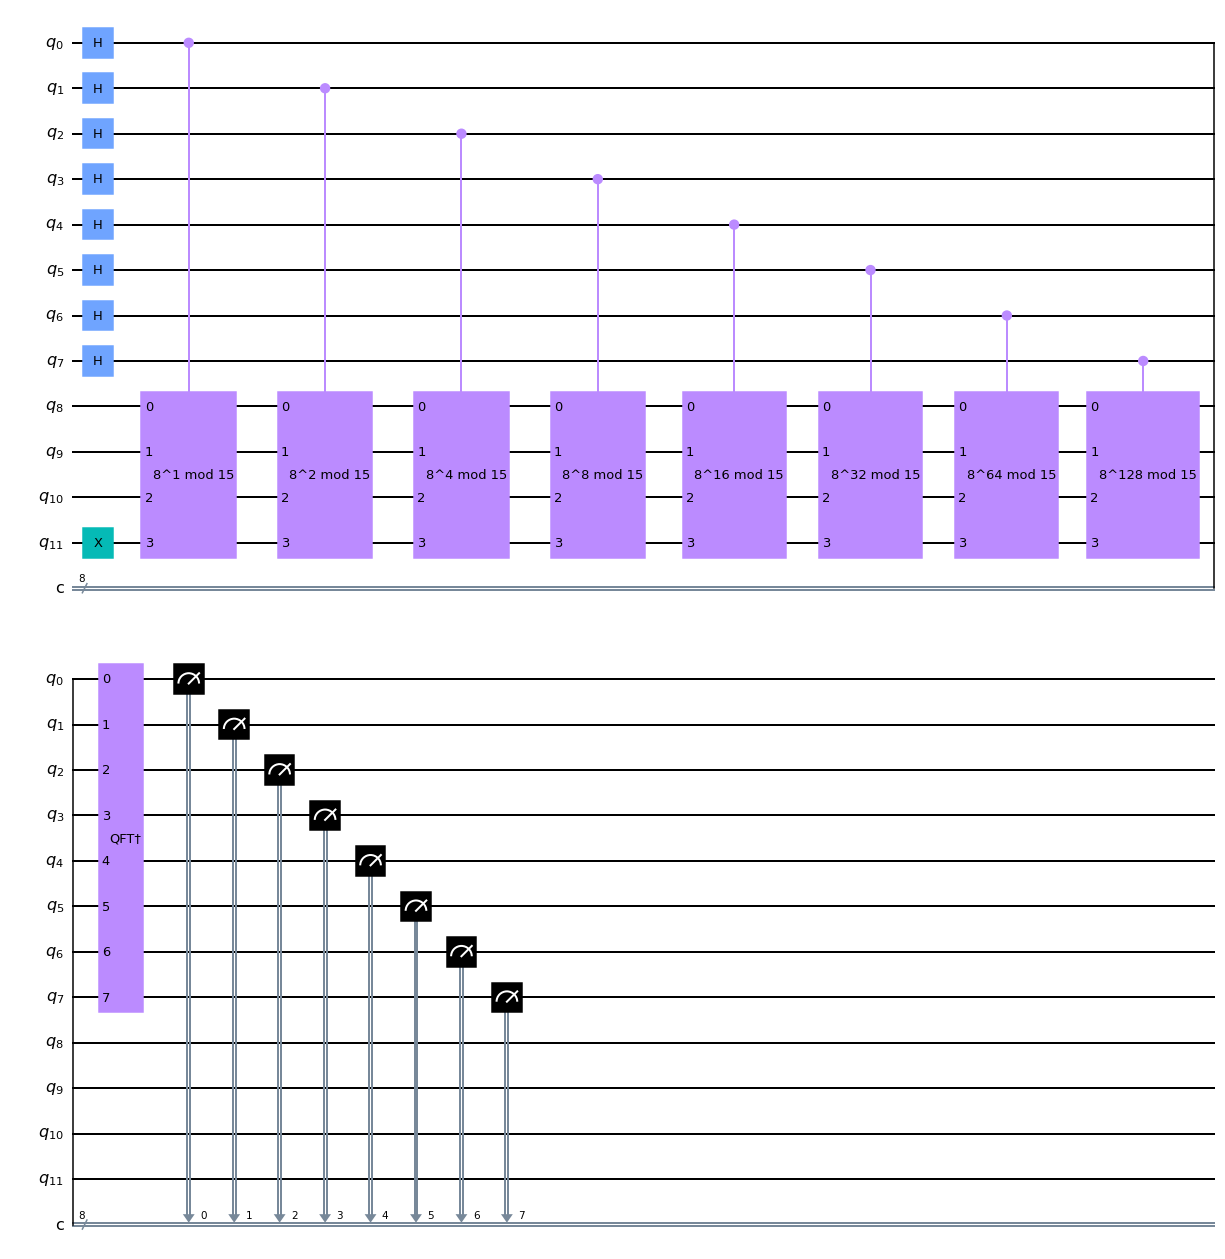

In [11]:
# Specify variables
n_count = 8 # number of counting qubits
a = 8

# n_count個の測定用量子ビットとUを操作するための4量子ビットで
# 量子回路を作る
qc = QuantumCircuit(n_count + 4, n_count)

# 測定用量子ビットを
# |+>状態に初期化
for q in range(n_count):
    qc.h(q)

# アンシラレジスターを|1>の状態にする
qc.x(3+n_count)

# 制御Uを操作
for q in range(n_count):
    qc.append(c_amod15(a, 2**q), 
             [q] + [i+n_count for i in range(4)])

# 逆QFTを操作
qc.append(qft_dagger(n_count), range(n_count))

# 回路を測定
qc.measure(range(n_count), range(n_count))
qc.draw('mpl')

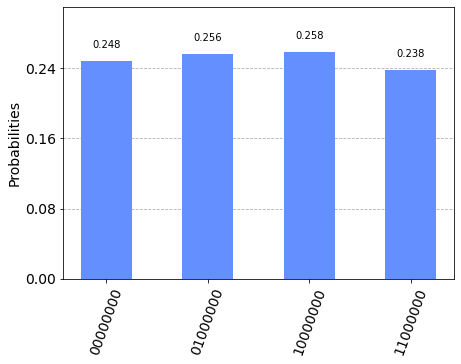

In [12]:
backend = Aer.get_backend('qasm_simulator')
results = execute(qc, backend, shots=2048).result()
counts = results.get_counts()
plot_histogram(counts)

In [13]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # 2進数を10進数に変換します
    phase = decimal/(2**n_count) # 固有値を探します
    measured_phases.append(phase)
    # これらの値をテーブルの行に追加します：
    rows.append(["%s(bin) = %i(dec)" % (output, decimal), 
                 "%i/%i = %.2f" % (decimal, 2**n_count, phase)])
# tabulateを使って、ASCIIテーブルとして行を印刷します：
print(tabulate(rows, 
               headers=["Register Output", "Phase"], 
               colalign=("left","right")))

Register Output                    Phase
------------------------  --------------
10000000(bin) = 128(dec)  128/256 = 0.50
01000000(bin) = 64(dec)    64/256 = 0.25
00000000(bin) = 0(dec)      0/256 = 0.00
11000000(bin) = 192(dec)  192/256 = 0.75


In [14]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, "%i/%i" % (frac.numerator, frac.denominator), frac.denominator])
# ASCIIテーブルを表示
print(tabulate(rows, 
               headers=["Phase", "Fraction", "Guess for r"], 
               colalign=('right','right','right')))

  Phase    Fraction    Guess for r
-------  ----------  -------------
    0.5         1/2              2
   0.25         1/4              4
      0         0/1              1
   0.75         3/4              4


測定された固有値の内、2つが正しい結果を与えたことが分かる。：$r = 4$
***

### a = 11 のとき：  
　まず、関数 $f(x)=a^x\ \rm{mod}\ \it{N}$ の周期 $r$ をグラフ上で確認しておく。

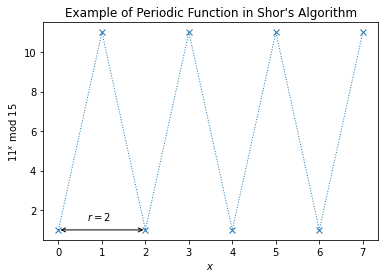

In [15]:
plot_fx(N = 15, a = 11, xlim = 8)

改めて量子位相推定(QPE)の回路を構成し、周期 $r$ のヒントとなる位相を測定する。

C:\Users\WataruOgaki\AppData\Local\Temp\ipykernel_24164\2071727995.py:9: DeprecationWarning: The QuantumCircuit.cu1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cp method instead, which acts identically.
  qc.cu1(-np.pi/float(2**(j-m)), m, j)


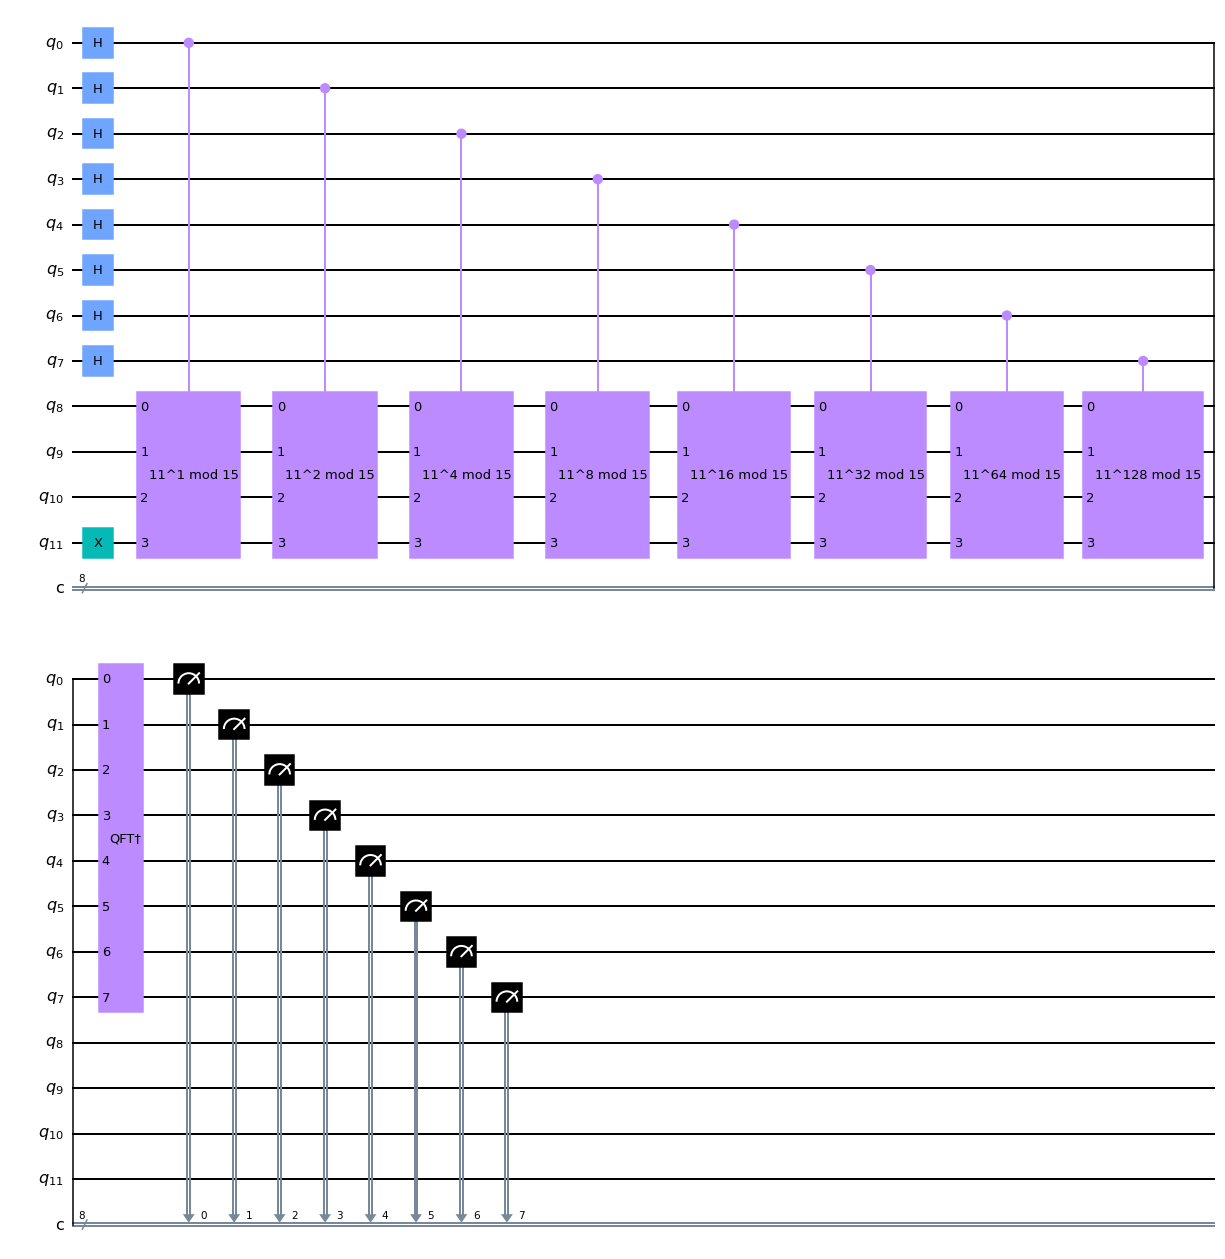

In [16]:
# Specify variables
n_count = 8 # number of counting qubits
a = 11

# n_count個の測定用量子ビットとUを操作するための4量子ビットで
# 量子回路を作る
qc = QuantumCircuit(n_count + 4, n_count)

# 測定用量子ビットを
# |+>状態に初期化
for q in range(n_count):
    qc.h(q)

# アンシラレジスターを|1>の状態にする
qc.x(3+n_count)

# 制御Uを操作
for q in range(n_count):
    qc.append(c_amod15(a, 2**q), 
             [q] + [i+n_count for i in range(4)])

# 逆QFTを操作
qc.append(qft_dagger(n_count), range(n_count))

# 回路を測定
qc.measure(range(n_count), range(n_count))
qc.draw('mpl')

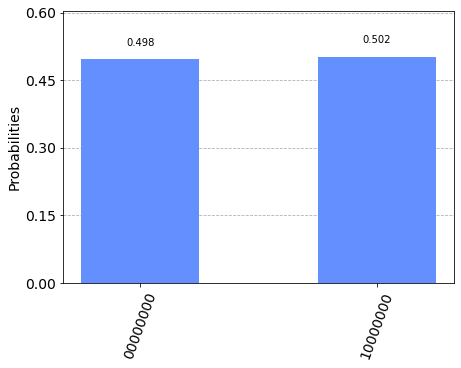

In [17]:
backend = Aer.get_backend('qasm_simulator')
results = execute(qc, backend, shots=2048).result()
counts = results.get_counts()
plot_histogram(counts)

In [18]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # 2進数を10進数に変換します
    phase = decimal/(2**n_count) # 固有値を探します
    measured_phases.append(phase)
    # これらの値をテーブルの行に追加します：
    rows.append(["%s(bin) = %i(dec)" % (output, decimal), 
                 "%i/%i = %.2f" % (decimal, 2**n_count, phase)])
# tabulateを使って、ASCIIテーブルとして行を印刷します：
print(tabulate(rows, 
               headers=["Register Output", "Phase"], 
               colalign=("left","right")))

Register Output                    Phase
------------------------  --------------
00000000(bin) = 0(dec)      0/256 = 0.00
10000000(bin) = 128(dec)  128/256 = 0.50


In [19]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, "%i/%i" % (frac.numerator, frac.denominator), frac.denominator])
# ASCIIテーブルを表示
print(tabulate(rows, 
               headers=["Phase", "Fraction", "Guess for r"], 
               colalign=('right','right','right')))

  Phase    Fraction    Guess for r
-------  ----------  -------------
      0         0/1              1
    0.5         1/2              2


今回は $r = 2$ で$s = 0, 1$ なので、それらに対応する2つの位相のみが得られている。